# Deploy machine learned models with ONNX

La plupart des libraires de machine learning sont optimisées pour entraîner des modèles et pas nécessairement les utiliser dans des sites internet online où l'exigence de rapidité est importante. [ONNX](https://onnx.ai/), une initiative open source proposée l'année dernière par Microsoft et Facebook est une réponse à ce problème. Ce talk illustrera ce concept avec un démo mêlant deep learning, [scikit-learn](http://scikit-learn.org/stable/) et [ML.net](https://github.com/dotnet/machinelearning), la librairie de machine learning open source écrite en C# et développée par Microsoft.

Most of machine learning libraries are optimized to train models and not necessarily to use them for fast predictions in online web services. [ONNX](https://onnx.ai/) is one solution started last year by Microsoft and Facebook. This presentation describes the concept and shows some examples with [scikit-learn](http://scikit-learn.org/stable/) and [ML.net](https://github.com/dotnet/machinelearning).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
from pyquickhelper.helpgen import NbImage

## Open source tools in this talk

### ML.net

* Open source in 2018
* [ML.net](https://github.com/dotnet/machinelearning)
* Machine learning library written in C#
* Used in many places in Microsoft Services (Bing, ...)
* Working on it for three years

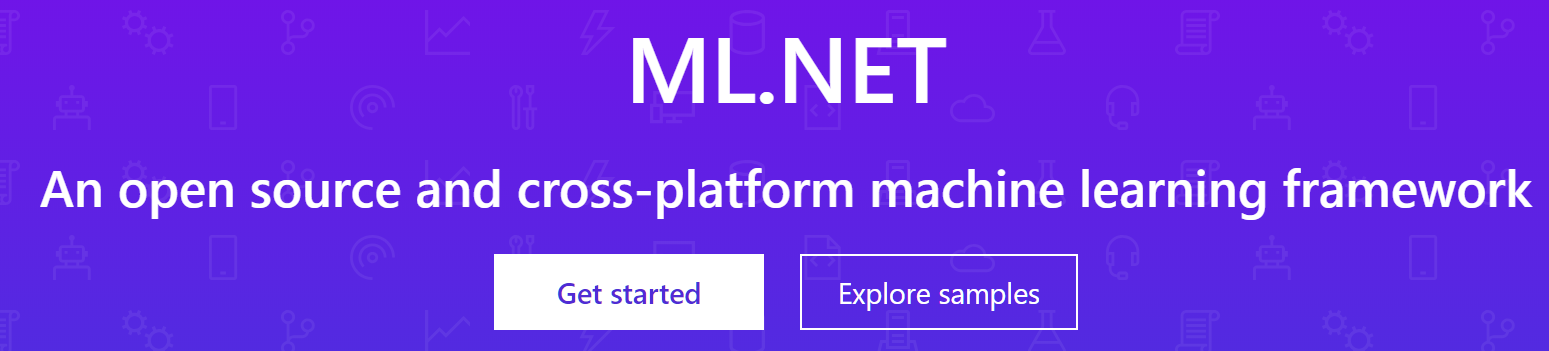

In [3]:
NbImage("mlnet.png", width=500)

### nimbusml

* Open source in 2018
* [nimbusml](https://github.com/Microsoft/NimbusML) Wrapper on [ML.net](https://github.com/dotnet/machinelearning)
* Working on it for a year

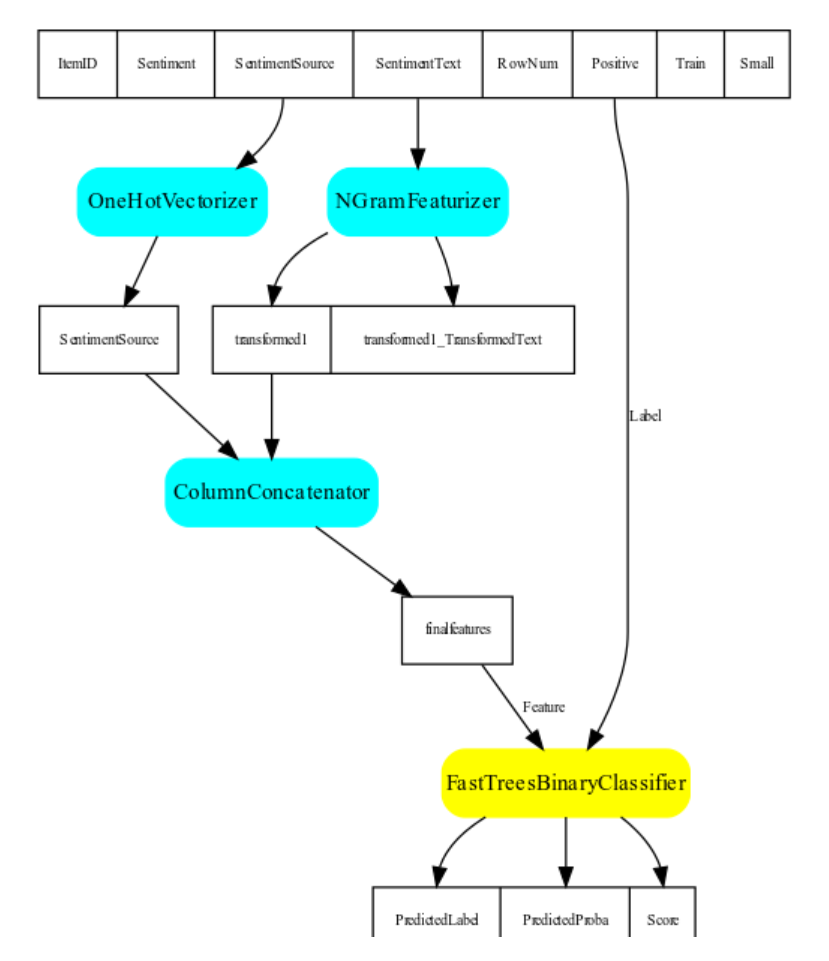

In [4]:
NbImage("nimbusml.png", width=300)

### onnx

* Serialisation library specialized for machine learning based on [Google.Protobuf](https://developers.google.com/protocol-buffers/)
* Open source in 2017
* [onnx](https://github.com/onnx/onnx)

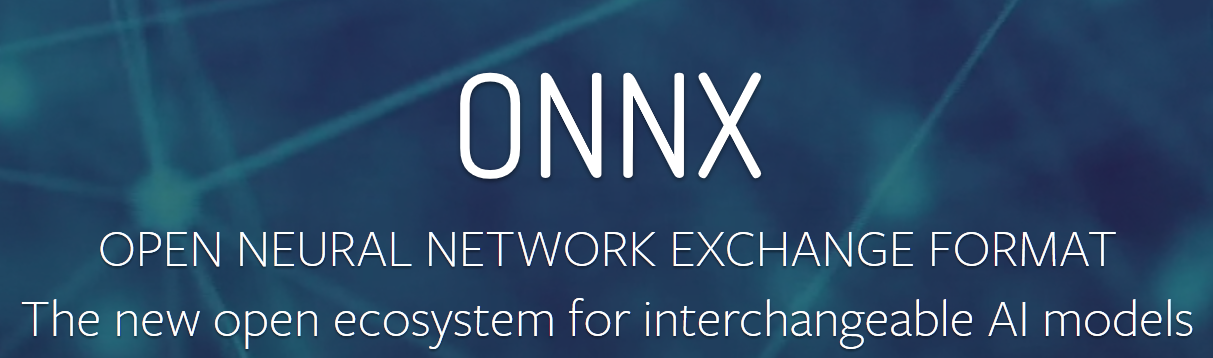

In [5]:
NbImage("onnx.png", width=500)

### onnxmltools

* Open source in 2017
* Converters for some machine learning including *scikit-learn*
* [onnxmltools](https://github.com/onnx/onnxmltools)
* Working on it for a year

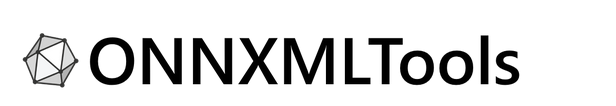

In [6]:
NbImage("onnxmltools.png")

### onnxruntime

* Open source in ????
* Available as a preview on [Pypi/onnxruntime](https://pypi.org/project/onnxruntime/)
* documentation is [here](https://docs.microsoft.com/en-us/python/api/overview/azure/onnx/intro?view=azure-onnx-py)
* Working on it for a couple of months

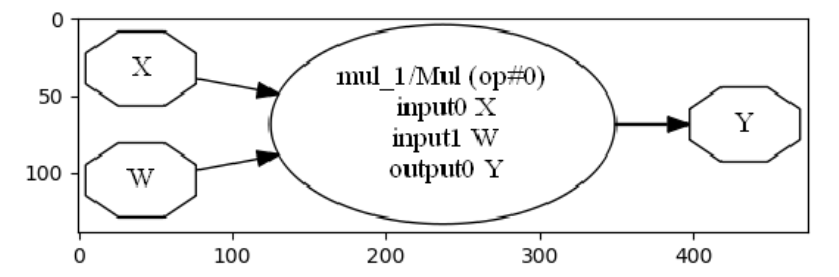

In [7]:
NbImage("onnxruntime.png", width=400)

### Others tools

* [scikit-learn](http://scikit-learn.org/)
* [xgboost](https://xgboost.readthedocs.io/en/latest/)
* [lightgbm](https://lightgbm.readthedocs.io/en/latest/)
* [keras](https://keras.io/)

## The problem about deployment

### Learn and predict

* Two different purposes not necessarily aligned for optimization
* **Learn** : computation optimized for large number of observations (*batch prediction*)
* **Predict** : computation optimized for one observation (*one-off prediction*)
* Machine learning libraries optimize the **learn** scenario.

### Illustration with a linear regression

We consider a datasets available in *scikit-learn*: [diabetes](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html)

In [8]:
measures_lr = []

In [9]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
diabetes_X_train = diabetes.data[:-20]
diabetes_X_test  = diabetes.data[-20:]
diabetes_y_train = diabetes.target[:-20]
diabetes_y_test  = diabetes.target[-20:]
diabetes_X_train[:1]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187235, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990842, -0.01764613]])

#### scikit-learn

In [10]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(diabetes_X_train, diabetes_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [11]:
clr.predict(diabetes_X_test[:1])

array([197.61846908])

In [12]:
from jupytalk.benchmark import timeexec
measures_lr += [timeexec("sklearn", "clr.predict(diabetes_X_test[:1])", context=globals())]

Average: 30.96 µs deviation 5.63 µs (with 50 runs) in [26.77 µs, 42.18 µs]


#### pure python

In [13]:
def python_prediction(X, coef, intercept):
    s = intercept
    for a, b in zip(X, coef):
        s += a * b
    return s

python_prediction(diabetes_X_test[0], clr.coef_, clr.intercept_)

197.61846907503298

In [14]:
measures_lr += [timeexec("python", "python_prediction(diabetes_X_test[0], clr.coef_, clr.intercept_)", context=globals())]

Average: 7.33 µs deviation 3.05 µs (with 50 runs) in [3.92 µs, 13.70 µs]


#### nimbusml

[nimbusml](https://docs.microsoft.com/en-us/nimbusml/overview) was released on 11/3/2018 and wraps [ML.net](https://github.com/dotnet/machinelearning) for Python.

In [15]:
from nimbusml.linear_model import OrdinaryLeastSquaresRegressor
nlr = OrdinaryLeastSquaresRegressor()
nlr.fit(diabetes_X_train, diabetes_y_train)

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Trainer solving for 11 parameters across 422 examples
Coefficient of determination R2 = 0.512226221150138, or 0.500358245995641 (adjusted)
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.3288372


OrdinaryLeastSquaresRegressor(caching='Auto', feature=None, l2_weight=1e-06,
               label=None, normalize='Auto',
               per_parameter_significance=True, weight=None)

In [16]:
nlr.predict(diabetes_X_test[:1])

0    197.618484
Name: Score, dtype: float32

In [17]:
measures_lr += [timeexec("nimbusml", "nlr.predict(diabetes_X_test[:1])", context=globals(), number=5, repeat=5)]

Average: 403.99 ms deviation 38.05 ms (with 5 runs) in [362.93 ms, 466.00 ms]


#### One nice feature about nimbusml: visualization

In [18]:
import pandas
import pprint
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.preprocessing.schema import ColumnConcatenator
from nimbusml.feature_extraction.categorical import OneHotVectorizer
from nimbusml.ensemble import FastTreesBinaryClassifier
from nimbusml import Pipeline, FileDataStream, Role

In [19]:
data = """
"ItemID","Sentiment","SentimentSource","SentimentText","RowNum","Positive","Train","Small"
1,0,"Sentiment140","is so sad for my APL friend.............",1,FALSE,TRUE,FALSE
2,0,"Sentiment140","I missed the New Moon trailer...",2,FALSE,TRUE,FALSE
3,1,"Sentiment140","omg its already 7:30 :O",3,TRUE,TRUE,FALSE
4,0,"Sentiment140",".. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...",4,FALSE,TRUE,FALSE
5,0,"Sentiment140","i think mi bf is cheating on me!!!       T_T",5,FALSE,TRUE,FALSE
6,0,"Sentiment140","or i just worry too much?",6,FALSE,TRUE,FALSE
7,1,"Sentiment140","Juuuuuuuuuuuuuuuuussssst Chillin!!",7,TRUE,TRUE,FALSE
8,0,"Sentiment140","Sunny Again        Work Tomorrow  :-|       TV Tonight",8,FALSE,TRUE,FALSE
9,1,"Sentiment140","handed in my uniform today . i miss you already",9,TRUE,TRUE,FALSE
"""

In [20]:
with open("data_train.csv", "w") as f:
    f.write(data.replace("\t", ","))

In [21]:
stream = FileDataStream.read_csv("data_train.csv")
stream.head()

,ItemID,Sentiment,SentimentSource,SentimentText,RowNum,Positive,Train,Small
0,1,0,Sentiment140,is so sad for my APL friend.............,1,0,1,0
1,2,0,Sentiment140,I missed the New Moon trailer...,2,0,1,0
2,3,1,Sentiment140,omg its already 7:30 :O,3,1,1,0
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...,4,0,1,0
4,5,0,Sentiment140,i think mi bf is cheating on me!!! T_T,5,0,1,0


In [22]:
transform_1 = NGramFeaturizer() << {'transformed1':'SentimentText'}
transform_2 = OneHotVectorizer() << 'SentimentSource'
transform_3 = ColumnConcatenator() << {'finalfeatures': ['transformed1', 'SentimentSource']}
algo = FastTreesBinaryClassifier() << {Role.Feature:'finalfeatures', Role.Label: "Positive"}

pipeline = Pipeline([transform_1, transform_2, transform_3, algo])

In [23]:
from nimbusml.utils.exports import dot_export_pipeline
dot_vis = dot_export_pipeline(pipeline, stream)

In [24]:
from jyquickhelper import RenderJsDot
RenderJsDot(dot_vis)

#### ml.net (C#)

The code is longer, some subleties are hidden.

In [25]:
from jupytalk.benchmark import make_dataframe
df = make_dataframe(diabetes_y_train, diabetes_X_train)
df.head(n=2)

,Label,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,151.0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,75.0,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204


In [26]:
df.to_csv("diabetes.csv", index=False)

In [27]:
%load_ext pyensae

In [28]:
%load_ext csharpyml

In [29]:
%%mlnet ReturnMLClass2

public class TrainTestDiabetes
{
    string _dataset;
    ScikitPipeline _pipeline;

    public TrainTestDiabetes(string ds)
    {
        _dataset = ds;
    }

    public void Train()
    {
        using (var env = new ConsoleEnvironment())
        {
            var df = DataFrameIO.ReadCsv(_dataset, sep: ',',
                                         dtypes: new ColumnType[] { NumberType.R4 });
            var concat = "Concat{col=Features:F0,F1,F2,F3,F4,F5,F6,F7,F8,F9}";
            var pipe = new ScikitPipeline(new[] { concat }, "ols");
            pipe.Train(df, "Features", "Label");
            _pipeline = pipe;
        }
    }

    public DataFrame Predict(double[] features)
    {
        DataFrame pred = null;
        var df = new DataFrame();
        df.AddColumn("Label", new float[] { 0f });
        for (int i = 0; i < features.Length; ++i)
            df.AddColumn(string.Format("F{0}", i), new float[] { (float)features[i] });
        _pipeline.Predict(df, ref pred);
        return pred;
    }
}

public static TrainTestDiabetes ReturnMLClass2(string ds)
{
    return new TrainTestDiabetes(ds);
}

<function csharpy.runtime.compile.create_cs_function.<locals>.<lambda>(*params)>

In [30]:
tt = ReturnMLClass2("diabetes.csv")

In [31]:
tt.Train()

In [32]:
cs = tt.Predict(diabetes_X_test[0])

In [33]:
from csharpyml.binaries import CSDataFrame
csdf = CSDataFrame(cs)
csdf.to_df()

,Label,F0,F1,F2,F3,F4,F5,F6,F7,F8,...,Features.1,Features.2,Features.3,Features.4,Features.5,Features.6,Features.7,Features.8,Features.9,Score
0,0.0,-0.078165,0.05068,0.077863,0.052858,0.078236,0.064447,0.02655,-0.002592,0.040672,...,0.05068,0.077863,0.052858,0.078236,0.064447,0.02655,-0.002592,0.040672,-0.009362,197.6185


In [34]:
measures_lr += [timeexec("mlnet (custom)", "tt.Predict(diabetes_X_test[0])", context=globals())]

Average: 22.91 µs deviation 24.46 µs (with 50 runs) in [16.60 µs, 33.60 µs]


#### Summary

In [35]:
import pandas
df = pandas.DataFrame(data=measures_lr)
df = df.set_index("legend").sort_values("average")
df

,average,code,deviation,first,first3,last3,max5,min5,repeat,run
legend,,,,,,,,,,
python,0.000007,"python_prediction(diabetes_X_test[0], clr.coef...",0.000003,0.000013,0.000011,0.000005,0.000014,0.000004,200,50
mlnet (custom),0.000023,tt.Predict(diabetes_X_test[0]),0.000024,0.000067,0.000075,0.000020,0.000034,0.000017,200,50
sklearn,0.000031,clr.predict(diabetes_X_test[:1]),0.000006,0.000031,0.000030,0.000027,0.000042,0.000027,200,50
nimbusml,0.403987,nlr.predict(diabetes_X_test[:1]),0.038046,0.466001,0.397936,0.396352,0.466001,0.362930,5,5


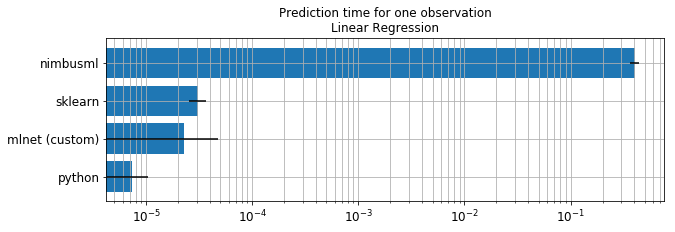

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nLinear Regression");

### Illustration with a random forest

In [37]:
measures_rf = []

#### scikit-learn

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
rf.fit(diabetes_X_train, diabetes_y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
measures_rf += [timeexec("sklearn", "rf.predict(diabetes_X_test[:1])", context=globals())]

Average: 527.90 µs deviation 92.71 µs (with 50 runs) in [461.08 µs, 702.14 µs]


#### XGBoost

In [40]:
from xgboost import XGBRegressor
xg = XGBRegressor(n_estimators=10)
xg.fit(diabetes_X_train, diabetes_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [41]:
measures_rf += [timeexec("xgboost", "xg.predict(diabetes_X_test[:1])", context=globals())]

Average: 48.21 µs deviation 17.52 µs (with 50 runs) in [37.17 µs, 90.03 µs]


#### LightGBM

In [42]:
from lightgbm import LGBMRegressor
lg = LGBMRegressor(n_estimators=10)
lg.fit(diabetes_X_train, diabetes_y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
measures_rf += [timeexec("lightgbm", "lg.predict(diabetes_X_test[:1])", context=globals())]

Average: 83.24 µs deviation 20.89 µs (with 50 runs) in [72.84 µs, 108.09 µs]


#### pure python

This would require to reimplement the prediction function.

#### nimbusml

In [44]:
from nimbusml.ensemble import FastTreesRegressor
nrf = FastTreesRegressor(num_trees=10)
nrf.fit(diabetes_X_train, diabetes_y_train)

Not adding a normalizer.
Making per-feature arrays
Changing data from row-wise to column-wise
Processed 422 instances
Binning and forming Feature objects
Reserved memory for tree learner: 170508 bytes
Starting to train ...
Not training a calibrator because it is not needed.
Elapsed time: 00:00:00.5831069


FastTreesRegressor(allow_empty_trees=True, bagging_size=0,
          baseline_alpha_risk=None, baseline_scores_formula=None,
          best_step_trees=False, bias=0.0, bundling='None', caching='Auto',
          categorical_split=False, compress_ensemble=False,
          disk_transpose=None, dropout_rate=0.0, early_stopping_metrics=1,
          early_stopping_rule=None, enable_pruning=False,
          entropy_coefficient=0.0, example_fraction=0.7,
          execution_times=False, feature=None, feature_compression_level=1,
          feature_flocks=True, feature_fraction=1.0,
          feature_reuse_penalty=0.0, feature_select_seed=123,
          filter_zero_lambdas=False, first_use_penalty=0.0,
          gain_conf_level=0.0, get_derivatives_sample_rate=1,
          group_id=None, histogram_pool_size=-1, label=None,
          learning_rate=0.2, max_categorical_groups_per_node=64,
          max_categorical_split_points=64, max_tree_output=100.0,
          max_trees_after_compression=-1,
  

In [45]:
measures_rf += [timeexec("nimbusml", "nrf.predict(diabetes_X_test[:1])", context=globals(), number=5, repeat=5)]

Average: 324.15 ms deviation 35.54 ms (with 5 runs) in [293.61 ms, 393.58 ms]


#### ml.net

In [46]:
%%mlnet ReturnMLClassRF

public class TrainTestDiabetesRF
{
    string _dataset;
    ScikitPipeline _pipeline;

    public TrainTestDiabetesRF(string ds)
    {
        _dataset = ds;
    }

    public void Train()
    {
        using (var env = new ConsoleEnvironment())
        {
            var df = DataFrameIO.ReadCsv(_dataset, sep: ',',
                                         dtypes: new ColumnType[] { NumberType.R4 });
            var concat = "Concat{col=Features:F0,F1,F2,F3,F4,F5,F6,F7,F8,F9}";
            var pipe = new ScikitPipeline(new[] { concat }, "ftr{iter=10}");
            pipe.Train(df, "Features", "Label");
            _pipeline = pipe;
        }
    }

    public DataFrame Predict(double[] features)
    {
        DataFrame pred = null;
        var df = new DataFrame();
        df.AddColumn("Label", new float[] { 0f });
        for (int i = 0; i < features.Length; ++i)
            df.AddColumn(string.Format("F{0}", i), new float[] { (float)features[i] });
        _pipeline.Predict(df, ref pred);
        return pred;
    }

    public DataFrame PredictBatch(int nf, double[] features)
    {
        DataFrame pred = null;
        var df = new DataFrame();
        int N = features.Length / nf;
        df.AddColumn("Label", Enumerable.Range(0, N).Select(i => (float)features[nf * i]).ToArray());
        for (int i = 0; i < nf; ++i)
            df.AddColumn(string.Format("F{0}", i), 
                         Enumerable.Range(0, N).Select(k => (float)features[nf * k + i]).ToArray());
        _pipeline.Predict(df, ref pred);
        return pred;
    }

    public void Read(string name)
    {
        _pipeline = new ScikitPipeline(name);
    }

    public void Save(string name)
    {
        _pipeline.Save(name, true);
    }
}

public static TrainTestDiabetesRF ReturnMLClassRF(string ds)
{
    return new TrainTestDiabetesRF(ds);
}

<function csharpy.runtime.compile.create_cs_function.<locals>.<lambda>(*params)>

In [47]:
trf = ReturnMLClassRF("diabetes.csv")
trf.Train()
measures_rf += [timeexec("mlnet (custom)", "trf.Predict(diabetes_X_test[0])", context=globals())]

Average: 34.21 µs deviation 71.61 µs (with 50 runs) in [18.21 µs, 48.61 µs]


#### Summary

In [48]:
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df

,average,code,deviation,first,first3,last3,max5,min5,repeat,run
legend,,,,,,,,,,
mlnet (custom),0.000034,trf.Predict(diabetes_X_test[0]),0.000072,0.001034,0.000377,0.000028,0.000049,0.000018,200,50
xgboost,0.000048,xg.predict(diabetes_X_test[:1]),0.000018,0.000132,0.000102,0.000042,0.000090,0.000037,200,50
lightgbm,0.000083,lg.predict(diabetes_X_test[:1]),0.000021,0.000328,0.000192,0.000094,0.000108,0.000073,200,50
sklearn,0.000528,rf.predict(diabetes_X_test[:1]),0.000093,0.000971,0.000649,0.000482,0.000702,0.000461,200,50
nimbusml,0.324145,nrf.predict(diabetes_X_test[:1]),0.035544,0.305277,0.311177,0.334363,0.393584,0.293611,5,5


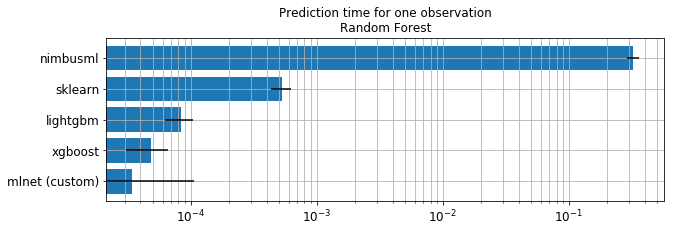

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

**Keep in mind**

* Produced are not necessarily the same.
* Performance is not compared.
* Order oof magnitude is important here.

### What is batch prediction?

* Instead of running $N$ times 1 prediction
* We run 1 time $N$ predictions

In [50]:
import numpy
memo = []
batch = [1, 2, 5, 7, 8, 10, 100, 200, 500, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 50000, 100000, 200000]

number = 10
repeat = 10
for i in batch:
    if i <= diabetes_X_test.shape[0]:
        mx = diabetes_X_test[:i]
    else:
        mxs = [diabetes_X_test] * (i // diabetes_X_test.shape[0] + 1)
        mx = numpy.vstack(mxs)
        mx = mx[:i]

    print("batch", "=", i)
    number = 10 if i <= 10000 else 2
    
    memo.append(timeexec("sklearn %d" % i, "rf.predict(mx)", context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "sklearn"
    
    memo.append(timeexec("xgboost %d" % i, "xg.predict(mx)", context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "xgboost"
    
    memo.append(timeexec("lightgbm %d" % i, "lg.predict(mx)", context=globals(), number=number, repeat=repeat))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "lightgbm"
    
    memo.append(timeexec("nimbusml %d" % i, "nrf.predict(mx)", repeat=2, number=2, context=globals()))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "nimbusml"
        
    memo.append(timeexec("mlnet %d" % i, "trf.PredictBatch(10, mx.ravel())", repeat=repeat, number=number, context=globals()))
    memo[-1]["batch"] = i
    memo[-1]["lib"] = "mlnet (custom)"

batch = 1
Average: 723.05 µs deviation 408.70 µs (with 10 runs) in [462.18 µs, 1.82 ms]
Average: 58.22 µs deviation 31.11 µs (with 10 runs) in [35.75 µs, 126.97 µs]
Average: 81.92 µs deviation 23.48 µs (with 10 runs) in [70.80 µs, 151.66 µs]
Average: 319.83 ms deviation 7.00 ms (with 2 runs) in [312.84 ms, 326.83 ms]
Average: 61.85 µs deviation 115.78 µs (with 10 runs) in [20.27 µs, 408.61 µs]
batch = 2
Average: 567.70 µs deviation 145.50 µs (with 10 runs) in [467.52 µs, 988.25 µs]
Average: 70.14 µs deviation 21.38 µs (with 10 runs) in [37.97 µs, 108.41 µs]
Average: 119.77 µs deviation 24.15 µs (with 10 runs) in [76.01 µs, 160.28 µs]
Average: 278.18 ms deviation 1.07 ms (with 2 runs) in [277.11 ms, 279.25 ms]
Average: 41.51 µs deviation 14.73 µs (with 10 runs) in [25.21 µs, 77.20 µs]
batch = 5
Average: 570.09 µs deviation 100.17 µs (with 10 runs) in [452.66 µs, 777.17 µs]
Average: 47.27 µs deviation 23.74 µs (with 10 runs) in [36.70 µs, 118.28 µs]
Average: 90.62 µs deviation 26.19 µs (

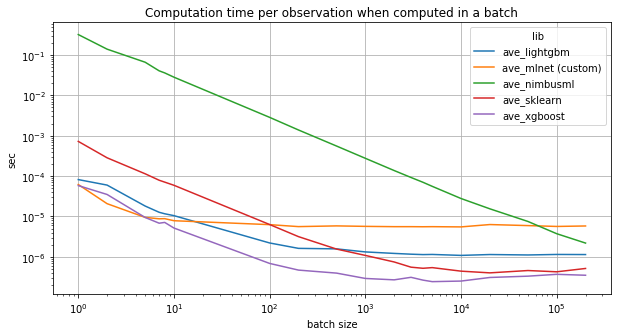

In [51]:
dfb = pandas.DataFrame(memo)[["average", "lib", "batch"]]
piv = dfb.pivot("batch", "lib", "average")
for c in piv.columns:
    piv["ave_" + c] = piv[c] / piv.index
libs = list(c for c in piv.columns if "ave_" in c)
ax = piv.plot(y=libs, logy=True, logx=True, figsize=(10, 5))
ax.set_title("Computation time per observation when computed in a batch")
ax.set_ylabel("sec")
ax.set_xlabel("batch size")
ax.grid(True);

## If we could switch libraries...

* Export one model from a library to another one.
* Optimisation is better for one-off prediction.

In [52]:
trf.Save("rf-mlnet.zip")

In [53]:
from nimbusml import Pipeline
pipe = Pipeline()
pipe.load_model("rf-mlnet.zip")

In [54]:
df = make_dataframe(diabetes_y_test.astype(numpy.float32), diabetes_X_test.astype(numpy.float32))

In [55]:
pipe.predict(df).head()

,Score
0,193.684052
1,128.217041
2,157.777420
3,70.880699
4,172.210541


It works because *ML.net* and *nimbusml* share the same core library.

## ONNX

### ONNX = efficient serialization

* Based on [google.protobuf](https://developers.google.com/protocol-buffers/)


### ONNX = language to describe models

* Standard format to describe machine learning
* Easier to exchange, export

### ONNX = machine learning oriented

* [operators ML](https://github.com/onnx/onnx/blob/master/docs/Operators-ml.md)
* [operators](https://github.com/onnx/onnx/blob/master/docs/Operators.md)

Can represent any mathematical function handling numerical and text features.

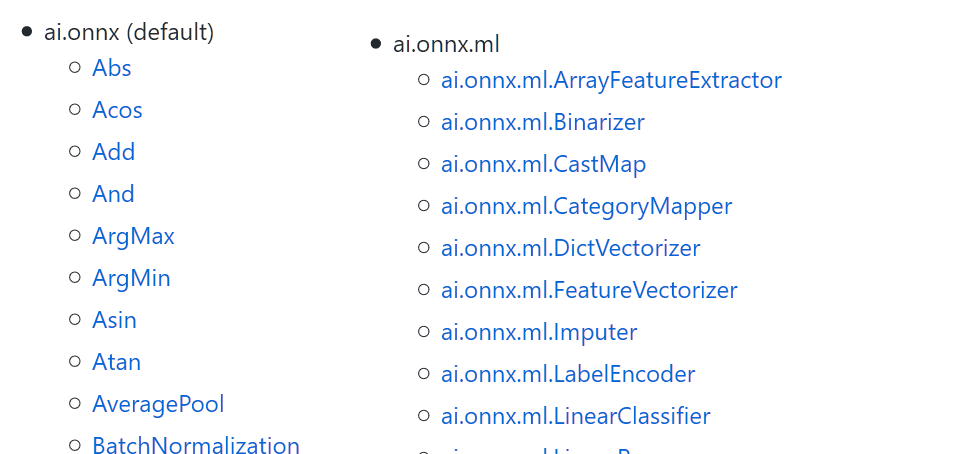

In [56]:
NbImage("onnxop.png", width=400)

### actively supported

* Microsoft
* Facebook
* first created to deploy deep learning models
* extended to other models

### Train somewhere, predict somewhere else

* Cannot optimize the code for training and predicting

| Training         | Predicting         |
|------------------|--------------------|
| Batch prediction | One-off prediction |
| Huge memory      | Small memory       |
| Huge data        | Small data         |
| .                | High latency       |

### ONNX Runtime

[ONNX Runtime for inferencing machine learning models now in preview](https://azure.microsoft.com/en-us/blog/onnx-runtime-for-inferencing-machine-learning-models-now-in-preview/)

Dedicated runtime for:

* CPU
* GPU
* ...

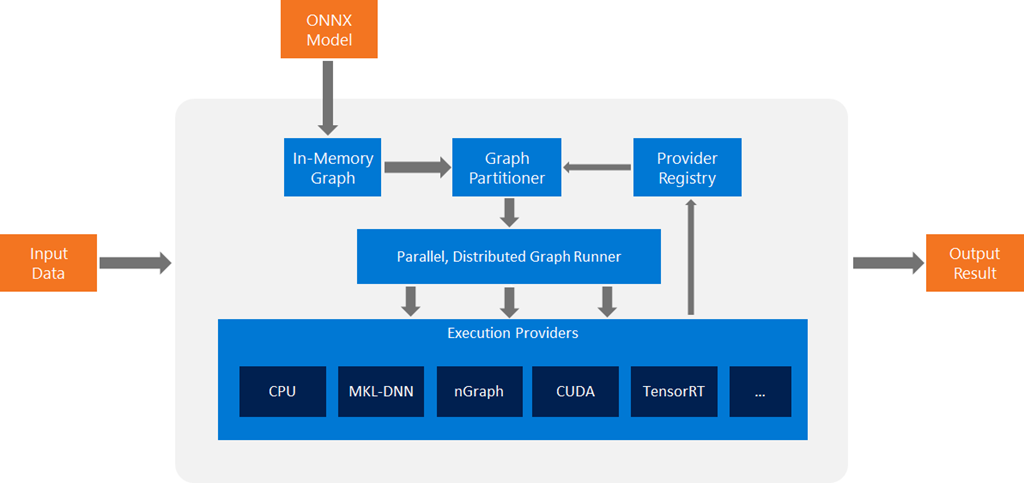

In [57]:
NbImage("onnxrt.png", width=800)

## ONNX demo

In [58]:
import onnxruntime

### back to random forest

In [59]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
from onnxmltools import convert_sklearn
from onnxmltools.convert.common.data_types import FloatTensorType
model_onnx = convert_sklearn(rf, "rf_diabetes", [('input', FloatTensorType([1, 10]))])

In [61]:
print(str(model_onnx)[:450] + "\n...")

ir_version: 3
producer_name: "OnnxMLTools"
producer_version: "1.3.0.1000"
domain: "onnxml"
model_version: 0
doc_string: ""
graph {
  node {
    input: "input"
    output: "variable"
    name: "TreeEnsembleRegressor"
    op_type: "TreeEnsembleRegressor"
    attribute {
      name: "n_targets"
      i: 1
      type: INT
    }
    attribute {
      name: "nodes_falsenodeids"
      ints: 272
      ints: 191
      ints: 190
      ints: 97
      ints: 
...


In [62]:
from onnxmltools.utils import save_model
save_model(model_onnx, 'rf_sklearn.onnx')

In [63]:
import onnxruntime

sess = onnxruntime.InferenceSession("rf_sklearn.onnx")

for i in sess.get_inputs():
    print('Input:', i)
for o in sess.get_outputs():
    print('Output:', o)

Input: NodeArg(name='input', type='tensor(float)', shape=[1, 10])
Output: NodeArg(name='variable', type='tensor(float)', shape=[1, 1])


In [64]:
import numpy

def predict_onnxrt(x):
    return sess.run(["variable"], {'input': x})

print("Prediction:", predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32)))

Prediction: [array([[205.60002]], dtype=float32)]


In [65]:
measures_rf += [timeexec("onnx", "predict_onnxrt(diabetes_X_test[:1].astype(numpy.float32))", context=globals())]

Average: 23.14 µs deviation 9.15 µs (with 50 runs) in [17.68 µs, 45.53 µs]


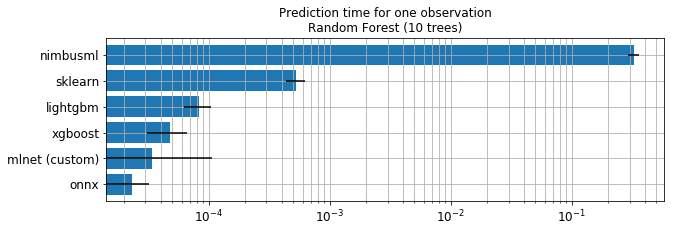

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10,3))
df = pandas.DataFrame(data=measures_rf)
df = df.set_index("legend").sort_values("average")
df[["average", "deviation"]].plot(kind="barh", logx=True, ax=ax, xerr="deviation",
                                  legend=False, fontsize=12, width=0.8)
ax.set_ylabel("")
ax.grid(b=True, which="major")
ax.grid(b=True, which="minor")
ax.set_title("Prediction time for one observation\nRandom Forest (10 trees)");

## Deep learning

* transfer learning with keras
* orther convert pytorch, caffee...

## Model zoo

### Tiny yolo

Source: [TinyYOLOv2 on onnx](https://mc.ai/tinyyolov2-on-onnx/)

To be continued